In [1]:
import numpy as np

In [2]:
%config InlineBackend.rc = {}
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
CC = [p['color'] for p in plt.rcParams['axes.prop_cycle']]
CM = 'Greys'

## Definitions

This is the definition of the gamma distribution probability density function we are using:

$$
    n(x; \alpha, \beta)
    = \frac{\beta^{\alpha+1} \, x^\alpha \, e^{-\beta x}}{\Gamma(\alpha + 1)}
$$

In [3]:
def gammapdf(x, alpha, beta=1.):
    '''Compute the gamma distribution PDF with parameters alpha, beta.'''
    from scipy.stats import gamma
    return gamma.pdf(x, alpha+1, scale=1/beta)

Its lensing efficiency can be computed analytically:

$$
    q(x; \alpha, \beta)
    = \frac{\Gamma(\alpha+1, \beta x)}{\Gamma(\alpha+1)}
    - \frac{\beta x}{\alpha} \, \frac{\Gamma(\alpha, \beta x)}{\Gamma(\alpha)}
$$

In [4]:
def gammaeff(x, alpha, beta=1.):
    '''Gamma distribution lensing efficiency with parameters alpha, beta.'''
    from scipy.special import gammaincc
    return gammaincc(alpha+1, beta*x) - (beta/alpha)*x*gammaincc(alpha, beta*x)

Convenience function to convert mean $\mu$ and inverse mean $\eta$ to the shape $\alpha$ and scale $\beta$ of the gamma distribution.

In [5]:
def gammaab(mu, eta):
    return 1/(mu*eta - 1), eta/(mu*eta - 1)

## Introduction

As an example, we want to show two distance distributions that have very distinct features but almost exactly the same lensing efficiency.

First, we define a distance range `x` for the example, in arbitrary units.

In [6]:
xx = np.arange(0, 4, 0.01)

The first distribution `n1` can be a simple gamma distribution, here with parameters $\alpha = 2$ and $\beta = 2$.
Its mean and inverse mean are $\mu = (\alpha+1)/\beta$ and $\eta = \beta/\alpha$. We also compute the corresponding lensing efficiency `q1`.

In [7]:
n1 = gammapdf(xx, 2, 2)
q1 = gammaeff(xx, 2, 2)

The second distribution `n2` is a mixture of two gamma distributions with respective weights $w_1$ and $w_2$. To closely match the lensing efficiency of the first distribution, we say that `n2` must recover the mean $\mu$ and inverse mean $\eta$ of the distribution `n1`:

$$
\begin{aligned}
    \mu &= w_1 \, \mu_1 + w_2 \, \mu_2 \\
    \eta &= w_1 \, \eta_1 + w_2 \, \eta_2 \;.
\end{aligned}
$$

Our goal is to have a visually distinct second distribution, so we aim for a bulk component in the mixture that is probably similar to the original distribution, and an additional sharp peak to the right. For this, it is more convenient to parametrise the matching conditions in terms of the means and variances of the components:

$$
\begin{aligned}
    \mu &= w_1 \, \mu_1 + w_2 \, \mu_2 \\
    \eta &= w_1 \, \frac{\mu_1}{\mu_1^2 - \sigma_1^2} + w_2 \, \frac{\mu_2}{\mu_2^2 - \sigma_2^2} \;.
\end{aligned}
$$

We can readily solve this using Mathematica or similar. Fixing the relative weights of the components to $w_1 = 9/10, w_2 = 1/10$, and the mean and variance of the sharp peak to $\mu_2 = 3$ and $\sigma_2^2 = 1/100$, we obtain $\mu_1 = 4/3$ and $\sigma_1^2 = 20974/39105$ for the bulk component. Converting from $\mu$ and $\sigma^2$ back to $\alpha$ and $\beta$, we find $\alpha_1 = 24273/10487$, $\beta_1 = 26070/10487$ and $\alpha_2 = 899$, $\beta_2 = 300$ as parameters of our mixture model.

In [8]:
n2 = (9/10)*gammapdf(xx, 24273/10487, 26070/10487) + (1/10)*gammapdf(xx, 899, 300)
q2 = (9/10)*gammaeff(xx, 24273/10487, 26070/10487) + (1/10)*gammaeff(xx, 899, 300)

The above reasoning uses the fact that the shape of the lensing efficiency $q(x)$ is mostly determined by the mean and inverse mean. To help visualise this, we set up a polygon `px, py` with vertices $\{0, 0\}$, $\{0, 1\}$, and $\{0, \eta^{-1}\}$ that covers the area under a hypothetical $q(x)$ curve with mean equal to inverse mean.

In [9]:
px = [0, 0, -(xx[1]-xx[0])/(q1[1]-q1[0])]
py = [0, 1, 0]

We can now plot the distributions, lensing efficiencies, and the polygon we created. The distributions look very distinct due to the second peak we created, while the lensing efficiencies are nearly indistinguishable.

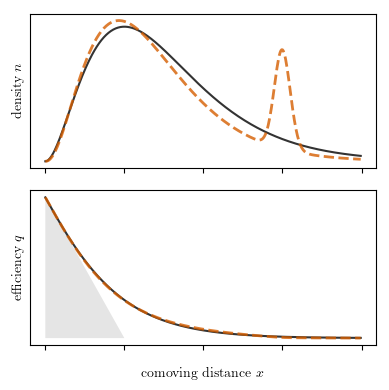

In [10]:
fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(xx, n1, '-', lw=1.5, alpha=0.8)
ax[0].plot(xx, n2, '--', lw=2.0, alpha=0.8)

ax[1].plot(xx, q1, '-', lw=1.5, alpha=0.8)
ax[1].plot(xx, q2, '--', lw=2.0, alpha=0.8)

ax[1].fill(px, py, fc='k', alpha=0.1)

ax[0].set_yticks([])
ax[0].tick_params(labelbottom=False)
ax[1].set_yticks([])
ax[1].tick_params(labelbottom=False)

ax[0].set_ylabel(r'density $n$')
ax[1].set_ylabel(r'efficiency $q$')
ax[1].set_xlabel(r'comoving distance $x$', labelpad=15)

fig.tight_layout()

plt.savefig('plots/intro.pdf')

plt.show()

## Parametric Lensing Efficiency

In this section, we demonstrate that we can successfully model the lensing efficiencies of a realistic redshift catalogue. Since we are interested in the true redshift distribution, we work with a synthetic catalogue that has both spectroscopic and realistic photometric redshifts. The selection for tomography is done exclusively on photometric data, as in real life.

First, use `astropy.Table` to conveniently load the catalogue `cat`. In this work, we use [The Buzzard Flock: Dark Energy Survey Synthetic Sky Catalogs](https://arxiv.org/abs/1901.02401) which will eventually be [publicly available](https://buzzardflock.github.io).

In [11]:
from astropy.table import Table

cat = Table.read('data/Buzzard_v1.9.2_Y1a_pz.fits')

Make sure the catalogue is the expected size.

In [12]:
len(cat)

12728829

Take the source redshift samples from the catalogue: The distributions we work with are the intrinsic redshifts `z_intr` and the photometric redshifts `z_phot`. These are stored in different columns in the catalogue, which we convert to plain arrays using `.data`.

In [13]:
z_intr = cat['redshift'].data
z_phot = cat['mc-z'].data

There is also a third kind of redshift we require: The photometric redshift `z_tomo` used for tomographic binning. For the Buzzard catalogue (actually, the DES Y1 methodology), this is a different column than the photometric redshift `z_phot`.

In [14]:
z_tomo = cat['mean-z'].data

Finally, the individual sources have different reliability weights associated with them, which we must take into account when we compute the number count histograms and lensing efficiencies.

In [15]:
w = cat['weight']

### Non-Tomographic Redshift Distributions

We start by taking stock of our catalogue. We want to look at the non-tomographic spectroscopic and photometric redshift distributions first. Since photometric redshift codes work generally well, we expect reasonable agreement between the distributions.

Define the redshift range we use for binning the number counts. These are used for visualisation only.

In [16]:
z = np.arange(0, 4, 0.01)

Also store the lower and upper bounds and midpoints of the redshift bins.

In [17]:
zl, zh = z[:-1], z[1:]
zm = (zl+zh)/2

Get redshift number count histograms `Nz_intr` and `Nz_phot` for the bins `z` we defined, using the intrinsic sample `z_intr` and the photometric sample `z_phot` individually.

In [18]:
Nz_intr, _ = np.histogram(z_intr, bins=z, weights=w)
Nz_phot, _ = np.histogram(z_phot, bins=z, weights=w)

Plot the marginal intrinsic and photometric redshift histograms `Nz_intr` and `Nz_phot` from the catalogue. These will be noisy, but that makes no difference; we are only taking a look.

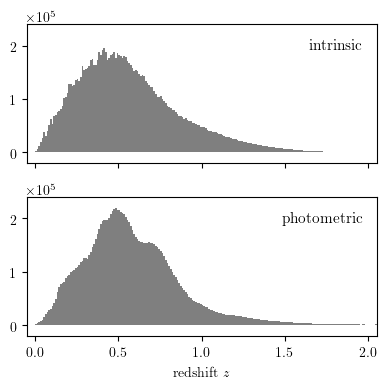

In [19]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)

ax[0].bar(zm, Nz_intr, zh-zl, alpha=0.5)
ax[1].bar(zm, Nz_phot, zh-zl, alpha=0.5)

ax[0].set_title('intrinsic', loc='right', x=0.96, y=0.75)
ax[1].set_title('photometric', loc='right', x=0.96, y=0.75)
ax[1].set_xlabel(r'redshift $z$')
ax[0].set_xlim(-0.05, 2.05)
ax[0].set_ylim(-0.2e5, 2.4e5)
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 2))

fig.tight_layout()

plt.savefig('plots/nz-phot-nontomo.pdf')

plt.show()

### Intrinsic vs Photometric Tomography

The issue with photometric redshifts appears in tomographic surveys, because the mapping between intrinsic and photometric redshifts is not one to one. This is usually shown in a $zz$ density plot of intrinsic and photometric redshifts, which we create here for our catalogue.

We compute a 2D histogram `Nzz` of number counts for intrinsic against photometric redshifts, using the same binning `z` as before. Note that we show the photometric redshifts for tomography, `z_tomo`.

In [20]:
Nzz, _, _ = np.histogram2d(z_intr, z_tomo, bins=[z, z], weights=w)

However, because we now have `z` $\times$ `z` bins, the number counts are noisy, and this makes it harder to get the overall picture. We therefore apply a median filter to `Nzz` to improve visualisation. The median is taken over `size=11` bins, that is a redshift range of `0.1` for our binning `z`, and assumes that the distribution vanishes at the boundary by setting `mode='constant'` with `cval=0`. All of this is still purely for visualisation.

In [21]:
from scipy.ndimage.filters import median_filter

Nzz = median_filter(Nzz, size=11, mode='constant', cval=0)

Plot the intrinsic against photometric redshift number counts `Nzz` in logarithmic scale. This should look reasonably similar to what has been found before in surveys.

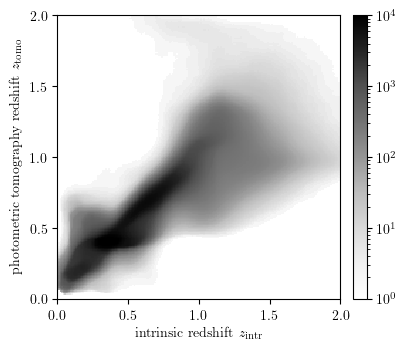

In [22]:
plt.figure(figsize=(4, 4))

plt.imshow(Nzz.T, extent=[z[0], z[-1], z[0], z[-1]],
           norm=colors.LogNorm(), cmap=CM, origin='bottom')

plt.xlabel(r'intrinsic redshift $z_{\rm intr}$')
plt.ylabel(r'photometric tomography redshift $z_{\rm tomo}$')
plt.clim(1e0, 1e4)
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.xticks([0, 0.5, 1, 1.5, 2])
plt.yticks([0, 0.5, 1, 1.5, 2])
plt.colorbar(orientation='vertical', fraction=0.0457, pad=0.04)

fig.tight_layout()

plt.savefig('plots/z_intr-z_tomo.pdf')

plt.show()

### Tomographic Redshift Distributions

Now comes the critical bit. We create the tomographic redshift bins by selecting sources based on their _photometric_ redshifts, then look at the resulting _spectroscopic_ redshift distributions in each tomographic bin.

Define `zb` as the edges of the tomographic redshift bins. Our choice, like our catalogue, matches DES Y1. Also store the number of bins `nb`.

In [23]:
zb = [0.20, 0.43, 0.63, 0.90, 1.30]
nb = len(zb) - 1

The actual selection is simple: Go through the tomographic bin edges `zb` and find the indices where the photometric redshift for binning `z_tomo` from the catalogue lies between the edges, `zb[i] <= z_tomo < zb[i+1]`. The results are stored in `sel_tomo`, which thus has one list of selected indices per tomographic bin.

In [24]:
sel_tomo = [np.where((a <= z_tomo) & (z_tomo < b)) for a, b in zip(zb, zb[1:])]

Select the sources in each tomographic bin using the selection from `sel_tomo` and compute the histograms. The result for intrinsic and photometric redshifts are stored in `Nz_intr_tomo` and `Nz_phot_tomo`, respectively.

In [25]:
Nz_intr_tomo = [np.histogram(z_intr[sel], bins=z, weights=w[sel])[0] for sel in sel_tomo]
Nz_phot_tomo = [np.histogram(z_phot[sel], bins=z, weights=w[sel])[0] for sel in sel_tomo]

We can now plot the intrinsic and photometric redshift distributions `N_intr_tomo` and `N_phot_tomo` after photometric redshift selection for the tomographic bins. The distributions clearly spill out of the nominal bin bounds, and outlier populations appear.

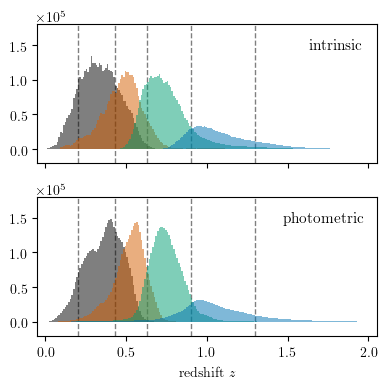

In [26]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)

for Nz in Nz_intr_tomo:
    ax[0].bar(zm, Nz, zh-zl, alpha=0.5, zorder=1)

for Nz in Nz_phot_tomo:
    ax[1].bar(zm, Nz, zh-zl, alpha=0.5, zorder=1)

for b in zb:
    ax[0].axvline(b, c='k', ls='--', lw=1.0, alpha=0.5, zorder=0)
    ax[1].axvline(b, c='k', ls='--', lw=1.0, alpha=0.5, zorder=0)

ax[0].set_title('intrinsic', loc='right', x=0.96, y=0.75)
ax[1].set_title('photometric', loc='right', x=0.96, y=0.75)
ax[1].set_xlabel(r'redshift $z$')
ax[0].set_xlim(-0.05, 2.05)
ax[0].set_ylim(-0.2e5, 1.8e5)
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 2))

fig.tight_layout()

plt.savefig('plots/nz-phot-tomo.pdf')

plt.show()

In light of these distributions, it might be interesting to see that the mean intrinsic redshift is actually within the nominal bounds of the tomographic redshift bins.

In [27]:
for a, b, sel in zip(zb, zb[1:], sel_tomo):
    print('photo-z bin = [{:.2f}, {:.2f})'.format(a, b))
    print('> mean z_intr = {:.3f}'.format(np.average(z_intr[sel], weights=w[sel])))
    print('> mean z_phot = {:.3f}'.format(np.average(z_phot[sel], weights=w[sel])))

photo-z bin = [0.20, 0.43)
> mean z_intr = 0.336
> mean z_phot = 0.363
photo-z bin = [0.43, 0.63)
> mean z_intr = 0.481
> mean z_phot = 0.519
photo-z bin = [0.63, 0.90)
> mean z_intr = 0.757
> mean z_phot = 0.749
photo-z bin = [0.90, 1.30)
> mean z_intr = 1.098
> mean z_phot = 1.054


### Tomographic Distance Distributions

Having taken a look at the provided redshift distributions, we move towards our stated goal of modelling the lensing efficiency for a tomographic survey. The first step is to convert the redshifts to comoving distances. This requires information about the cosmology.

In [28]:
from astropy.cosmology import FlatLambdaCDM

Set up the cosmology from `astropy`. We use a flat $\Lambda$CDM cosmology called `cosmo` with matter fraction `Om0 = 0.286` as used in the creation of the catalogue. To remove the dependency of the comoving distances on the Hubble parameter $h$, we work in units of ${\rm Mpc}/h$ by setting `H0=100`.

In [29]:
cosmo = FlatLambdaCDM(Om0=0.286, H0=100)

Make sure the cosmology was set up ok.

In [30]:
print(cosmo)

FlatLambdaCDM(H0=100 km / (Mpc s), Om0=0.286, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)


Given `cosmo`, converting the intrinsic redshift samples `z_intr` and photometric redshift samples `z_phot` to their respective comoving distances `x_intr` and `x_phot` is straightforward.

In [31]:
x_intr = cosmo.comoving_distance(z_intr).to('Mpc').value
x_phot = cosmo.comoving_distance(z_phot).to('Mpc').value

Compute the tomographic bin edges `xb` in comoving distance.

In [32]:
xb = [cosmo.comoving_distance(b).to('Mpc').value for b in zb]

Set up the distance bins `x` for computing number count histograms.

In [33]:
x = np.arange(0, 4000, 10)

As before, also store the lower and upper bin edges `xl, xh` and the midpoints `xm` in separate arrays.

In [34]:
xl, xh = x[:-1], x[1:]
xm = (xl + xh)/2

Compute the number count histograms `Nx_intr_tomo` and `Nx_phot_tomo`. Since the distance samples `x_intr` and `x_phot` are in the same order as the redshift samples `z_intr` and `z_phot`, we can reuse the selection `sel_tomo` we have performed on the latter also for the former.

In [35]:
Nx_intr_tomo = [np.histogram(x_intr[sel], bins=x, weights=w[sel])[0] for sel in sel_tomo]
Nx_phot_tomo = [np.histogram(x_phot[sel], bins=x, weights=w[sel])[0] for sel in sel_tomo]

Plot the source distance histograms from `Nx_intr_tomo` and `Nx_phot_tomo`. These look roughly similar to the redshift histograms, but have a non-trivial distortion due to the fact that the comoving distance flattens with increasing redshift

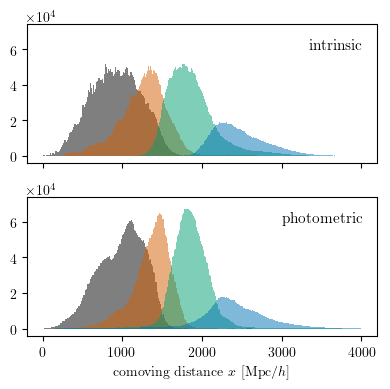

In [36]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)

for Nx in Nx_intr_tomo:
    ax[0].bar(xm, Nx, xh-xl, alpha=0.5, zorder=1)

for Nx in Nx_phot_tomo:
    ax[1].bar(xm, Nx, xh-xl, alpha=0.5, zorder=1)

ax[0].set_title('intrinsic', loc='right', x=0.96, y=0.75)
ax[1].set_title('photometric', loc='right', x=0.96, y=0.75)
ax[1].set_xlabel(r'comoving distance $x$ [Mpc/$h$]')
ax[0].set_ylim(-0.4e4, 7.4e4)
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 2))

fig.tight_layout()

plt.savefig('plots/nx-phot-tomo.pdf')

plt.show()

### Lensing Efficiencies

The next step is to compute the lensing efficiencies for the tomographically-selected samples. This is **not** done via the histograms we have plotted previously, but rather through the exact sum for the lensing efficiency of a sample of sources.

The function that computes the lensing efficiency at comoving distances `x` for a sample of sources at comoving distances `s`, with optional weights `w`. This is done as a (weighted) average:

$$
    q_{\rm samp}(x)
    = \frac{1}{\sum_{i=1}^{N} w_i} \sum_{i=1}^{N} w_i \, \frac{(x_i - x)^+}{x_i}
$$

In [37]:
def sampeff(x, s, weights=None):
    '''Compute lensing efficiency from samples.'''
    return np.array([np.average(np.clip(s-t, 0, None)/s, weights=weights) for t in x])

Compute the lensing efficiencies `qx_intr_tomo` from the intrinsic distances, as well as `qx_phot_tomo` from the distances coming from photometric redshifts. Due to the exact summation, this might take a while.

In [38]:
qx_intr_tomo = [sampeff(x, x_intr[sel], weights=w[sel]) for sel in sel_tomo]
qx_phot_tomo = [sampeff(x, x_phot[sel], weights=w[sel]) for sel in sel_tomo]

Plot the tomographic lensing efficiencies from intrinsic and photometric redshifts, and the absolute error $\Delta q$ one obtains by using the photometric redshifts instead of the intrinsic ones.

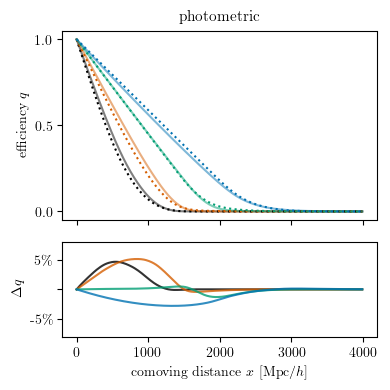

In [39]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=False,
                       gridspec_kw={'height_ratios': [2, 1]})

for qx in qx_intr_tomo:
    ax[0].plot(x, qx, ':', lw=1.5, alpha=1.0, zorder=1)

ax[0].set_prop_cycle(None)

for qx in qx_phot_tomo:
    ax[0].plot(x, qx, '-', lw=1.5, alpha=0.5, zorder=0)

for qx1, qx2 in zip(qx_intr_tomo, qx_phot_tomo):
    ax[1].plot(x, qx2 - qx1, lw=1.5, alpha=0.8, zorder=0)

ax[0].set_title('photometric')
ax[1].set_xlabel(r'comoving distance $x$ [Mpc/$h$]')
ax[0].set_ylabel(r'efficiency $q$')
ax[1].set_ylabel(r'$\Delta q$')
ax[1].set_ylim(-7.99e-2, 7.99e-2)
ax[0].set_yticks([0, 0.5, 1])
ax[1].set_yticks([-0.05, 0, 0.05])
ax[1].set_yticklabels([r'-5\%', r'', r'5\%'])

fig.tight_layout()

plt.savefig('plots/qx-phot-tomo.pdf')

plt.show()

### Efficiency Parameters

Finally, we show that the efficiency parameters are able to adequately describe real lensing efficiencies, better than the photometric redshifts can.

Compute `mu_intr_tomo`, `eta_intr_tomo` for the intrinsic distributions, and `mu_phot_tomo`, `eta_phot_tomo` for the photometric distributions.

In [40]:
mu_intr_tomo = [np.average(x_intr[sel], weights=w[sel]) for sel in sel_tomo]
eta_intr_tomo = [np.average(1/x_intr[sel], weights=w[sel]) for sel in sel_tomo]

mu_phot_tomo = [np.average(x_phot[sel], weights=w[sel]) for sel in sel_tomo]
eta_phot_tomo = [np.average(1/x_phot[sel], weights=w[sel]) for sel in sel_tomo]

Fit the parametric form to the intrinsic lensing efficiency. The target function `qfit` is the integrated square deviation $\int_{0}^{\infty} \! [q_{\rm para}(x) - q_{\rm intr}(x)]^2 \, dx$ between parametric efficiency $q_{\rm univ}$ and intrinsic efficiency $q_{\rm intr}$.

In [41]:
def qfit(alpha_beta, x, qx):
    '''Integrated square deviation dq^2(x) between parametric and intrinsic efficiency.
    
    The model is parametrised in terms of `alpha` and `beta`. The result is
    compared to the true efficiency `qx` and integrated over the `x` range.
    '''
    return np.trapz((gammaeff(x, *alpha_beta) - qx)**2, x)

Perform the fit using `scipy.optimize.minimize` with the target function `qfit(params, x, qx)` for each individual efficiency `qx` in `qx_intr_tomo`. The initial parameters `x0 = gammab(mu, eta)` of the fit are computed from the `mu_intr_tomo` and `eta_intr_tomo` arrays. We use the Nelder-Mead algorithm for simplicity, and ask it to show its progress with the `disp = True` option.

In [42]:
from scipy.optimize import minimize

para_tomo = [minimize(qfit, x0=gammaab(mu, eta), args=(x, qx),
                      method='Nelder-Mead', tol=1e-10,
                      options={'maxiter': 1000, 'disp': True})
             for qx, mu, eta in zip(qx_intr_tomo, mu_intr_tomo, eta_intr_tomo)]

Optimization terminated successfully.
         Current function value: 0.050939
         Iterations: 88
         Function evaluations: 185
Optimization terminated successfully.
         Current function value: 0.049720
         Iterations: 81
         Function evaluations: 179
Optimization terminated successfully.
         Current function value: 0.015561
         Iterations: 92
         Function evaluations: 191
Optimization terminated successfully.
         Current function value: 0.008931
         Iterations: 89
         Function evaluations: 191


In [43]:
qx_para_tomo = [gammaeff(x, *p.x) for p in para_tomo]

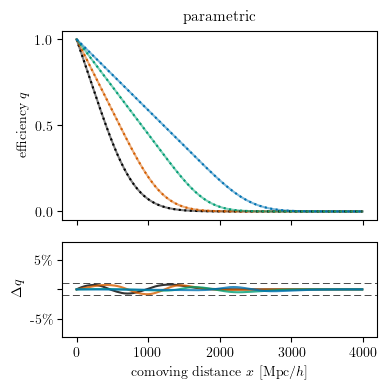

In [44]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=False,
                       gridspec_kw={'height_ratios': [2, 1]})

for qx in qx_para_tomo:
    ax[0].plot(x, qx, ':', lw=1.5, alpha=1.0, zorder=1)

ax[0].set_prop_cycle(None)

for qx in qx_para_tomo:
    ax[0].plot(x, qx, '-', lw=1.5, alpha=0.5, zorder=0)

for qx1, qx2 in zip(qx_intr_tomo, qx_para_tomo):
    ax[1].plot(x, qx2 - qx1, lw=1.5, alpha=0.8, zorder=1)

ax[1].axhline(-0.01, c='k', ls='--', lw=0.5, dashes=(10, 5), zorder=0)
ax[1].axhline(+0.01, c='k', ls='--', lw=0.5, dashes=(10, 5), zorder=0)

ax[0].set_title('parametric')
ax[1].set_xlabel(r'comoving distance $x$ [Mpc/$h$]')
ax[0].set_ylabel(r'efficiency $q$')
ax[1].set_ylabel(r'$\Delta q$')
ax[1].set_ylim(-7.99e-2, 7.99e-2)
ax[0].set_yticks([0, 0.5, 1])
ax[1].set_yticks([-0.05, 0, 0.05])
ax[1].set_yticklabels([r'-5\%', r'', r'5\%'])

fig.tight_layout()

plt.savefig('plots/qx-para-tomo.pdf')

plt.show()

In [45]:
mu_para_tomo = [(p.x[0]+1)/p.x[1] for p in para_tomo]
eta_para_tomo = [p.x[1]/p.x[0] for p in para_tomo]

In [46]:
def mu_eta_table(names, mus, etas):
    nn = len(names)
    nam = '| ' + ' '*3 + ' |' + ' {:^16} |'*nn
    hdr = '| {:^3} |' + ' {:^8}{:^8} |'*nn
    col = ['bin'] + ['mu', 'eta']*nn
    lin = '+-' + '-'*3 + '-+' + ('-' + '-'*16 + '-+')*nn
    row = '| {:^3} |' + ' {:^8.3f}{:^8.3f} |'*nn
    print(lin)
    print(nam.format(*names))
    print(lin)
    print(hdr.format(*col))
    print(lin)
    for i, (mu_model, eta_model) in enumerate(zip(zip(*mus), zip(*etas))):
        val = [i+1] + [v for m, e in zip(mu_model, eta_model)
                       for v in (1e-3*m, 1e3*e)]
        print(row.format(*val))
    print(lin)
    
mu_eta_table(
    ['intrinsic', 'photometric', 'parametric'],
    [mu_intr_tomo, mu_phot_tomo, mu_para_tomo],
    [eta_intr_tomo, eta_phot_tomo, eta_para_tomo]
)

+-----+------------------+------------------+------------------+
|     |    intrinsic     |   photometric    |    parametric    |
+-----+------------------+------------------+------------------+
| bin |    mu     eta    |    mu     eta    |    mu     eta    |
+-----+------------------+------------------+------------------+
|  1  |  0.920   1.301   |  0.989   1.156   |  0.929   1.235   |
|  2  |  1.273   0.855   |  1.365   0.769   |  1.278   0.832   |
|  3  |  1.865   0.554   |  1.856   0.552   |  1.860   0.551   |
|  4  |  2.476   0.412   |  2.387   0.449   |  2.473   0.412   |
+-----+------------------+------------------+------------------+


### Density Fit

In [47]:
def nfit(alpha_beta, x, nx):
    return np.sum((gammapdf(x, *alpha_beta) - nx)**2)

In [48]:
nx_intr_tomo = [np.histogram(x_intr[sel], bins=x, weights=w[sel], density=True)[0] for sel in sel_tomo]

In [49]:
nfit_tomo = [minimize(nfit, x0=gammaab(mu, eta), args=(xm, nx),
                      method='Nelder-Mead', tol=1e-10,
                      options={'maxiter': 1000, 'disp': True})
             for nx, mu, eta in zip(nx_intr_tomo, mu_intr_tomo, eta_intr_tomo)]

Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 96
         Function evaluations: 196
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 89
         Function evaluations: 192
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 89
         Function evaluations: 188
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 85
         Function evaluations: 182


In [50]:
nx_nfit_tomo = [gammapdf(x, *p.x) for p in nfit_tomo]
nx_para_tomo = [gammapdf(x, *p.x) for p in para_tomo]

In [51]:
qx_nfit_tomo = [gammaeff(x, *p.x) for p in nfit_tomo]

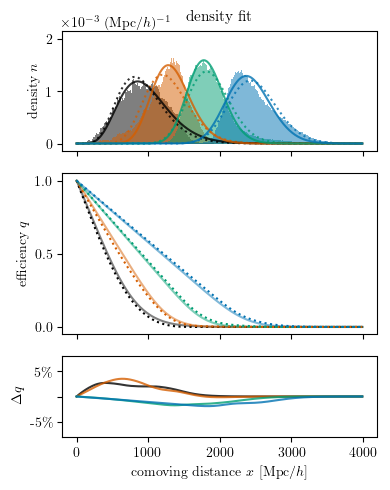

In [52]:
fig, ax = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(4, 5),
                      gridspec_kw={'height_ratios': [3, 4, 2]})

for nx in nx_intr_tomo:
    ax[0].bar(xm, nx, xh-xl, alpha=0.5, zorder=0)

for nx in nx_para_tomo:
    ax[0].plot(x, nx, ':', alpha=0.8, lw=1.5, zorder=1)
    
ax[0].set_prop_cycle(None)

for nx in nx_nfit_tomo:
    ax[0].plot(x, nx, alpha=0.8, lw=1.5, zorder=2)

for qx in qx_intr_tomo:
    ax[1].plot(x, qx, ':', lw=1.5, alpha=1.0, zorder=1)

ax[1].set_prop_cycle(None)

for qx in qx_nfit_tomo:
    ax[1].plot(x, qx, '-', lw=1.5, alpha=0.5, zorder=0)

for qx1, qx2 in zip(qx_intr_tomo, qx_nfit_tomo):
    ax[2].plot(x, qx2 - qx1, lw=1.5, alpha=0.8, zorder=0)

ax[0].set_title('density fit')
ax[2].set_xlabel(r'comoving distance $x$ [Mpc/$h$]')
ax[0].set_ylabel(r'density $n$')
ax[1].set_ylabel(r'efficiency $q$')
ax[2].set_ylabel(r'$\Delta q$')
ax[0].set_ylim(-0.15e-3, 2.15e-3)
ax[2].set_ylim(-7.99e-2, 7.99e-2)
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 2))
ax[0].yaxis.offsetText.set_visible(False)
ax[0].text(0, 1.03, r'$\times 10^{-3}$ (Mpc/$h$)$^{-1}$', transform=ax[0].transAxes)
ax[1].set_yticks([0, 0.5, 1])
ax[2].set_yticks([-0.05, 0, 0.05])
ax[2].set_yticklabels([r'-5\%', r'', r'5\%'])

fig.tight_layout()

plt.savefig('plots/nx-qx-nfit-tomo.pdf')

plt.show()

### Generalised Gamma Distribution

In [53]:
def gengammapdf(x, alpha, beta=1., gamma=1.):
    '''Compute the generalised gamma distribution PDF with parameters alpha, beta, gamma.'''
    from scipy.stats import gengamma
    return gengamma.pdf(x, (alpha+1)/gamma, gamma, scale=1/beta)

In [54]:
def gengammaeff(x, alpha, beta=1., gamma=1.):
    '''Generalised gamma distribution lensing efficiency with parameters alpha, beta, gamma.'''
    from scipy.special import gammaincc, gammaln
    u = gammaincc((alpha+1)/gamma, (beta*x)**gamma)
    v = gammaincc(alpha/gamma, (beta*x)**gamma)
    w = np.exp(gammaln(alpha/gamma) - gammaln((alpha+1)/gamma))
    return u - (beta*x)*(v*w)

In [55]:
def genqfit(alpha_beta_gamma, x, qx):
    return np.trapz((gengammaeff(x, *alpha_beta_gamma) - qx)**2, x)

For the two higher-redshift bins, there is a degeneracy in the fit, so we don't mind that the optimisation does not terminate regularly.

In [56]:
genqfit_tomo = [minimize(genqfit, x0=(*gammaab(mu, eta), 1.), args=(x, qx),
                         method='Nelder-Mead', tol=1e-10,
                         options={'maxiter': 1200, 'disp': True})
             for qx, mu, eta in zip(qx_intr_tomo, mu_intr_tomo, eta_intr_tomo)]

Optimization terminated successfully.
         Current function value: 0.001284
         Iterations: 586
         Function evaluations: 1046
Optimization terminated successfully.
         Current function value: 0.006968
         Iterations: 1189
         Function evaluations: 2081


In [57]:
qx_genqfit_tomo = [gengammaeff(x, *genqfit.x) for genqfit in genqfit_tomo]

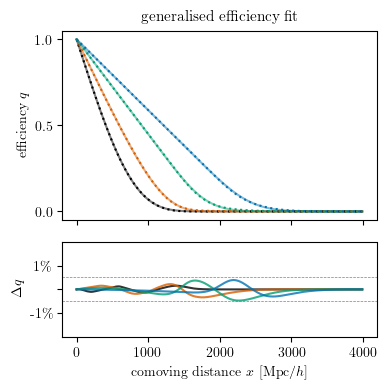

In [58]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=False,
                       gridspec_kw={'height_ratios': [2, 1]})

for qx in qx_intr_tomo:
    ax[0].plot(x, qx, ':', lw=1.5, alpha=1.0, zorder=1)

ax[0].set_prop_cycle(None)

for qx in qx_genqfit_tomo:
    ax[0].plot(x, qx, '-', lw=1.5, alpha=0.5, zorder=0)

for qx1, qx2 in zip(qx_intr_tomo, qx_genqfit_tomo):
    ax[1].plot(x, qx2 - qx1, lw=1.5, alpha=0.8, zorder=1)

ax[1].axhline(-0.005, c='k', ls='--', lw=0.5, alpha=0.5, zorder=0)
ax[1].axhline(+0.005, c='k', ls='--', lw=0.5, alpha=0.5, zorder=0)

ax[0].set_title('generalised efficiency fit')
ax[1].set_xlabel(r'comoving distance $x$ [Mpc/$h$]')
ax[0].set_ylabel(r'efficiency $q$')
ax[1].set_ylabel(r'$\Delta q$')
ax[1].set_ylim(-1.99e-2, 1.99e-2)
ax[0].set_yticks([0, 0.5, 1])
ax[1].set_yticks([-0.01, 0, 0.01])
ax[1].set_yticklabels([r'-1\%', r'', r'1\%'])

fig.tight_layout()

plt.savefig('plots/qx-genpara-tomo.pdf')

plt.show()

### Outliers

In [59]:
n1 = 0.8*gammapdf(xx, *gammaab(1, 8/7))
q1 = 0.8*gammaeff(xx, *gammaab(1, 8/7))

In [60]:
n2 = 0.2*gammapdf(xx, *gammaab(3, 1/3 + 1/1000))
q2 = 0.2*gammaeff(xx, *gammaab(3, 1/3 + 1/1000))

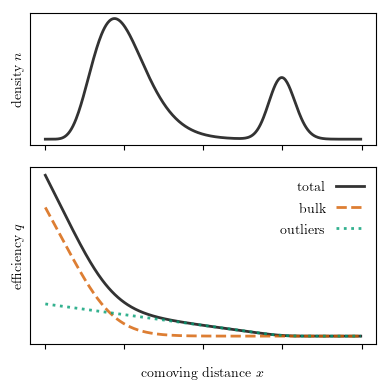

In [61]:
fig, ax = plt.subplots(2, 1, sharex=True,
                      gridspec_kw={'height_ratios': [3, 4]})

ax[0].plot(xx, n1+n2, '-', lw=2.0, alpha=0.8)

ax[1].plot(xx, q1+q2, '-', lw=2.0, alpha=0.8, label='total')
ax[1].plot(xx, q1, '--', lw=2.0, alpha=0.8, label='bulk')
ax[1].plot(xx, q2, ':', lw=2.0, alpha=0.8, label='outliers')

ax[0].set_yticks([])
ax[0].tick_params(labelbottom=False)
ax[1].set_yticks([])
ax[1].tick_params(labelbottom=False)

ax[0].set_ylabel(r'density $n$')
ax[1].set_ylabel(r'efficiency $q$')
ax[1].set_xlabel(r'comoving distance $x$', labelpad=15)

ax[1].legend(frameon=False, markerfirst=False)

fig.tight_layout()

plt.savefig('plots/outliers.pdf')

plt.show()

## Cosmological Parameter Inference

In [62]:
from astropy.io.fits import HDUList, Column, BinTableHDU

col_z = [Column(name='Z_LOW', array=zl, format='D'),
         Column(name='Z_MID', array=zm, format='D'),
         Column(name='Z_HIGH', array=zh, format='D')]

col_Nz_intr_tomo = [Column(name='BIN{}'.format(i+1), array=nz, format='D')
                    for i, nz in enumerate(Nz_intr_tomo)]

col_Nz_phot_tomo = [Column(name='BIN{}'.format(i+1), array=nz, format='D')
                    for i, nz in enumerate(Nz_phot_tomo)]

hdu_Nz_intr_tomo = BinTableHDU.from_columns(col_z + col_Nz_intr_tomo)
hdu_Nz_intr_tomo.header['NZDATA'] = True
hdu_Nz_intr_tomo.header['EXTNAME'] = 'NZ_INTR'
hdu_Nz_intr_tomo.header['NBIN'] = nb
hdu_Nz_intr_tomo.header['NZ'] = len(z)-1

hdu_Nz_phot_tomo = BinTableHDU.from_columns(col_z + col_Nz_phot_tomo)
hdu_Nz_phot_tomo.header['NZDATA'] = True
hdu_Nz_phot_tomo.header['EXTNAME'] = 'NZ_PHOT'
hdu_Nz_phot_tomo.header['NBIN'] = nb
hdu_Nz_phot_tomo.header['NZ'] = len(zl)

hdul = HDUList()
hdul.append(hdu_Nz_intr_tomo)
hdul.append(hdu_Nz_phot_tomo)
hdul.writeto('data/redshift_distributions.fits', overwrite=True)

In [63]:
with open('data/number_density_params.ini', 'w') as f:
    f.write('; generated values for fixed parametric efficiencies\n')
    f.write('\n')
    f.write('[number_density_params]\n')
    for i, (mu, eta) in enumerate(zip(mu_para_tomo, eta_para_tomo)):
        f.write('; bin {}\n'.format(i+1))
        f.write('mu_{}  = {:.16e} ; [Mpc/h]\n'.format(i+1, mu))
        f.write('eta_{} = {:.16e} ; [h/Mpc]\n'.format(i+1, eta))

Now use CosmoSIS to generate chains for analysis by running the following in the notebook directory:

```shell
# make all necessary chains (takes a *long* time)
$ make chains
```

Alternatively, multiple chains can be generated in parallel, by calling

```shell
# chain for intrinsic redshifts
$ make chains/intr.txt

# chain for photometric redshifts
$ make chains/phot.txt

# chain for parametric efficiencies
$ make chains/para.txt
```

from different shells. If you want to change how CosmoSIS is called, e.g. to use MPI, pass the `COSMOSIS` environment variable to make, or set it in the Makefile.

**Note:** The default settings for the samplers are in "draft mode". For publication quality, they should be significantly sharpened.

In [64]:
with open('data/number_density_ranges.ini', 'w') as f:
    f.write('; generated values for efficiency parameter ranges\n')
    f.write('\n')
    f.write('[number_density_params]\n')
    for i, (mu, eta) in enumerate(zip(mu_para_tomo, eta_para_tomo)):
        f.write('; bin {}\n'.format(i+1))
        f.write('mu_{}      = {:.16e} {:.16e} {:.16e} ; [Mpc/h]\n'.format(i+1, 0, mu, 2*mu))
        f.write('inv_eta_{} = {:.16e} {:.16e} {:.16e} ; [Mpc/h]\n'.format(i+1, 0, 1/eta, 2/eta))

In [65]:
for p in [.01, .02, .05, .1, .2, .5, 1.]:
    with open('data/priors-{:g}.ini'.format(100*p), 'w') as f:
        f.write('; generated values for efficiency parameter priors\n')
        f.write('\n')
        f.write('[number_density_params]\n')
        for i, (mu, eta) in enumerate(zip(mu_para_tomo, eta_para_tomo)):
            f.write('; bin {}\n'.format(i+1))
            f.write('mu_{}      = uniform {:.16e} {:.16e}\n'.format(i+1, (1-p)*mu, (1+p)*mu))
            f.write('inv_eta_{} = uniform {:.16e} {:.16e}\n'.format(i+1, (1-p)/eta, (1+p)/eta))

```shell
# chain using X% priors
$ make chains/priors-X.txt
```

**Note:** The chains with priors use emcee for sampling, and output samples after every iteration. That makes it possible to experiment with the results before the run has completed.

### Fixed Source Distributions

In [66]:
from chainconsumer import ChainConsumer

In [67]:
chains_param = [r'$\Omega_m$', r'$\sigma_8$']
chains_truth = [0.286, 0.82]

In [68]:
chains = ChainConsumer()

for file, name in [('chains/intr.txt', 'intrinsic'),
                   ('chains/phot.txt', 'photometric'),
                   ('chains/para.txt', 'parametric')]:
    chain = np.genfromtxt(file, names=True, deletechars='')
    chains.add_chain(
        [
            chain['cosmological_parameters--omega_m'],
            chain['cosmological_parameters--sigma8_input']
        ],
        parameters=chains_param,
        posterior=chain['post'],
        weights=chain['weight'],
        name=name
    )

Since we are using nested sampling, we can plot the weights of the chains to check that their runs went well – in which case the curves should be good-looking bumps that cut off close to zero on the right.

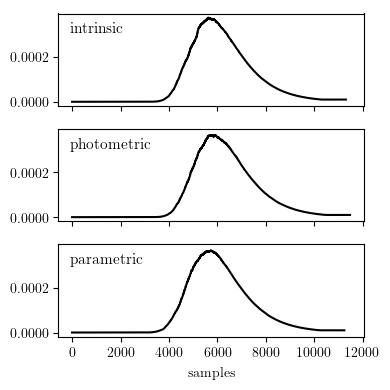

In [69]:
fig, _ = plt.subplots(len(chains.chains), 1, sharex=True, sharey=True)
for ax, ch in zip(fig.axes, chains.chains):
    ax.plot(ch.weights)
    ax.set_title(ch.name, loc='left', x=0.04, y=0.68)
fig.axes[-1].set_xlabel('samples')
plt.tight_layout()
plt.show()

Next, we configure `ChainConsumer` to produce the kind of contour plot we want ...

In [70]:
chains.configure(
    statistics='mean',              # which statistics to use
    plot_hists=True,                # show marginal densities
    colors=[CC[0], CC[2], CC[1]],   # set colours of contours
    spacing=1.0,                    # spacing between panels
    kde=False,                      # kernel density estimation
    smooth=False,                   # smoothing of contours
    bins=1.2,                       # binning factor
    shade=[True, False, True],      # shade contours?
    shade_alpha=0.2,                # transparency of shading
    shade_gradient=0.0,             # gradient of shading
    bar_shade=True,                 # shade histograms?
    linewidths=1.5,                 # line widths for chains
    linestyles=['-', ':', '-'],     # line styles for chains
    diagonal_tick_labels=False,     # rotate tick labels
    sigmas=[2]                      # which contours to show
);

... and finally plot it.

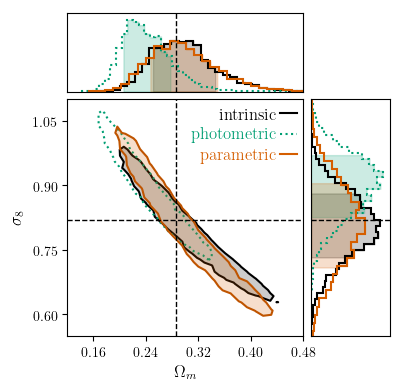

In [71]:
fig = chains.plotter.plot(
    parameters=chains_param,
    truth=chains_truth,
    extents=[(0.12, 0.48), (0.55, 1.10)],
    figsize=(3.8, 3.8),
    display=False
)
fig.savefig('plots/contours.pdf')
plt.show()

We can also look at a table of the marginal constraints.

In [72]:
print(chains.analysis.get_latex_table())

\begin{table}
    \centering
    \caption{}
    \label{tab:model_params}
    \begin{tabular}{ccc}
        \hline
		Model & $\Omega_m$ & $\sigma_8$ \\ 
		\hline
		intrinsic & $0.299\pm 0.047$ & $0.807\pm 0.074$ \\ 
		photometric & $0.242\pm 0.036$ & $0.898\pm 0.072$ \\ 
		parametric & $0.298\pm 0.051$ & $0.807\pm 0.098$ \\ 
		\hline
    \end{tabular}
\end{table}


In [73]:
print('+-' + '-'*12 + '---' + '-'*8 + '-+')
print('| {:^23s} |'.format('figure of merit'))
print('+-' + '-'*12 + '-+-' + '-'*8 + '-+')
for c in chains.chains:
    _, cov = chains.analysis.get_covariance(c)
    fom = 1/np.sqrt(np.linalg.det(cov))
    print('| {:12s} | {:8.2f} |'.format(c.name, fom))
print('+-' + '-'*12 + '-+-' + '-'*8 + '-+')

+-------------------------+
|     figure of merit     |
+--------------+----------+
| intrinsic    |  1217.80 |
| photometric  |  1618.67 |
| parametric   |   946.61 |
+--------------+----------+


### Efficiency Parameter Priors

In [74]:
chains = []

for perc in [2, 5, 10, 20, 100]:

    name = 'chains/priors-{}.txt'.format(perc)

    chain = np.genfromtxt(name, names=True, deletechars='')

    print('loaded', name, 'with', len(chain), 'samples')

    # burn-in
    chain = chain[100000::]

    print('burned', name, 'in to', len(chain), 'samples')

    chains.append(chain)

loaded chains/priors-2.txt with 613100 samples
burned chains/priors-2.txt in to 513100 samples
loaded chains/priors-5.txt with 605200 samples
burned chains/priors-5.txt in to 505200 samples
loaded chains/priors-10.txt with 568900 samples
burned chains/priors-10.txt in to 468900 samples
loaded chains/priors-20.txt with 470900 samples
burned chains/priors-20.txt in to 370900 samples
loaded chains/priors-100.txt with 547100 samples
burned chains/priors-100.txt in to 447100 samples


In [75]:
cosmo_chains = []

for chain in chains:
    cosmo_chains.append([
        chain['cosmological_parameters--omega_m'],
        chain['cosmological_parameters--sigma8_input']
    ])

cosmo_param = [r'$\Omega_m$', r'$\sigma_8$']
cosmo_truth = [0.286, 0.82]

In [76]:
cosmo_fixed = [(0.298, 0.051),
               (0.807, 0.098),
               (946.61, None)]

In [77]:
mueta_chains = [[] for i in range(len(chains))]

mueta_param = []
mueta_truth = []

for i, (tru_mu, tru_eta) in enumerate(zip(mu_para_tomo, eta_para_tomo)):
    for j, chain in enumerate(chains):
        mueta_chains[j] += [
            1e-3*chain['number_density_params--mu_{}'.format(i+1)],
            1e-3*chain['number_density_params--inv_eta_{}'.format(i+1)]
        ]

    mueta_param += [r'$\mu_{}$'.format(i+1), r'$\eta^{{-1}}_{}$'.format(i+1)]
    mueta_truth += [1e-3*tru_mu, 1e-3/tru_eta]

In [78]:
priors_edges = [1, 2, 5, 10, 20, 100]

In [79]:
priors_width = []
priors_chain = []
priors_nsamp = []

for a, b, c, p in zip(priors_edges, priors_edges[1:], cosmo_chains, mueta_chains):
    n = int(50*(np.log10(b) - np.log10(a)))

    priors_width.append([])
    priors_chain.append([])
    priors_nsamp.append([])

    for perc in np.logspace(np.log10(a), np.log10(b), n):
        low = np.multiply(mueta_truth, (100 - perc)/100)[:, np.newaxis]
        upp = np.multiply(mueta_truth, (100 + perc)/100)[:, np.newaxis]

        pick = np.all((p >= low) & (p < upp), axis=0).nonzero()

        priors_width[-1].append(perc)
        priors_chain[-1].append(np.take(c, pick[0], axis=1))
        priors_nsamp[-1].append(len(pick[0]))

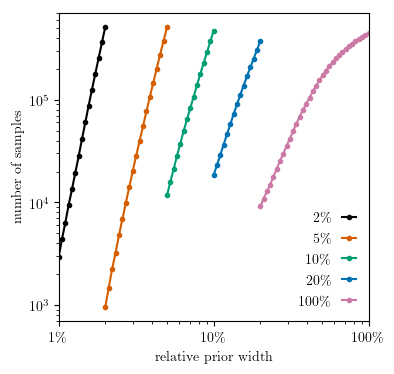

In [80]:
for w, n in zip(priors_width, priors_nsamp):
    plt.plot(w, n, '.-', label=r'{:g}\%'.format(w[-1]))

plt.legend(frameon=False, markerfirst=False,
           handlelength=1.0)

plt.xlabel('relative prior width')
plt.ylabel('number of samples')

plt.loglog()
plt.xlim(1, 100)
plt.xticks([1, 10, 100])
plt.gca().xaxis.set_ticklabels([r'1\%', r'10\%', r'100\%'])

plt.show()

In [81]:
priors_mus = []
priors_std = []
priors_cov = []

for chain in priors_chain:
    m, s, v = [], [], []

    for c in chain:
        m.append(np.mean(c, axis=1))
        s.append(np.std(c, axis=1))
        v.append(np.cov(c))

    priors_mus.append(np.asarray(m))
    priors_std.append(np.asarray(s))
    priors_cov.append(np.asarray(v))

In [82]:
priors_fom = []

for cov in priors_cov:
    fom = [1./np.sqrt(np.linalg.det(c)) for c in cov]

    priors_fom.append(np.asarray(fom))

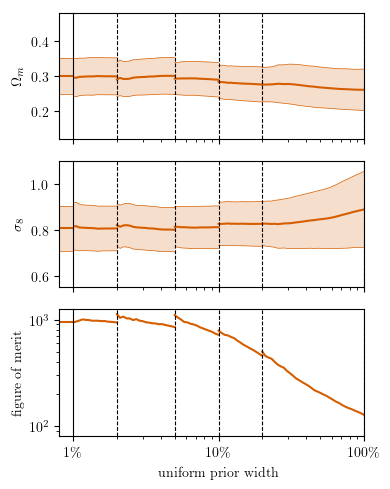

In [83]:
fig, ax = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(4, 5),
                       gridspec_kw={'width_ratios': [1, 20]})

for i, (p, a) in enumerate(zip(cosmo_param, ax)):
    for w, m, s in zip(priors_width, priors_mus, priors_std):
        a[1].fill_between(w, m[:, i]-s[:, i], m[:, i]+s[:, i],
                          facecolor=CC[1], alpha=0.2)
        a[1].plot(w, m[:, i]-s[:, i], c=CC[1], lw=0.5)
        a[1].plot(w, m[:, i]+s[:, i], c=CC[1], lw=0.5)
        a[1].plot(w, m[:, i], c=CC[1], lw=1.5)

for w, f in zip(priors_width, priors_fom):
    ax[-1,1].plot(w, f, c=CC[1], ls='-', lw=1.5)

for l, a in zip(cosmo_param + ['figure of merit'], ax):
    a[0].set_ylabel(l)

for f, a in zip(cosmo_fixed, ax):
    if f[1] is not None:
        a[0].fill_between([0, 1], [f[0]-f[1]]*2, [f[0]+f[1]]*2,
                          facecolor=CC[1], alpha=0.2)
        a[0].plot([0, 1], [f[0]-f[1]]*2, c=CC[1], lw=0.5)
        a[0].plot([0, 1], [f[0]+f[1]]*2, c=CC[1], lw=0.5)

    for b in priors_edges[1:]:
        a[1].axvline(b, c='k', lw=0.8, ls=(0, (3.5, 1.5)))

    a[0].plot([0, 1], [f[0]]*2, c=CC[1], ls='-', lw=1.5)

    a[0].spines['right'].set_visible(False)
    a[1].tick_params(which='both', left=False)

ax[-1,1].loglog()
ax[-1,0].set_xlim(-0, 1)
ax[-1,0].set_xticks([])
ax[-1,1].set_xlim(1, 100)
ax[-1,1].set_xticks([1, 10, 100])
ax[-1,1].set_xticklabels([r'1\%', r'10\%', r'100\%'])
ax[-1,1].set_xlabel('uniform prior width')

ax[0,0].set_ylim(0.12, 0.48)
ax[1,0].set_ylim(0.55, 1.10)
ax[2,0].set_ylim(0.81e2, 1.25e3)

fig.tight_layout()
fig.subplots_adjust(wspace=0)

fig.savefig('plots/priors.pdf')

plt.show()

In [84]:
chains = ChainConsumer()

for w, c in zip(priors_width, priors_chain):
    chains.add_chain(
        c[-1].T,
        parameters=cosmo_param,
        name=r'{:g}\%'.format(w[-1])
    )

In [85]:
chains.configure(
    statistics='mean',              # which statistics to use
    plot_hists=True,                # show marginal densities
    colors=CC,                      # set colours of contours
    spacing=1.0,                    # spacing between panels
    kde=False,                      # kernel density estimation
    smooth=False,                   # smoothing of contours
    bins=1.0,                       # binning factor
    plot_contour=True,              # draw contours?
    shade=False,                    # shade contours?
    plot_point=True,                # plot central points?
    bar_shade=False,                # shade histograms?
    linewidths=1.5,                 # line widths for chains
    linestyles='-',                 # line styles for chains
    diagonal_tick_labels=False,     # rotate tick labels?
    sigmas=[1]                      # which contours to show
);

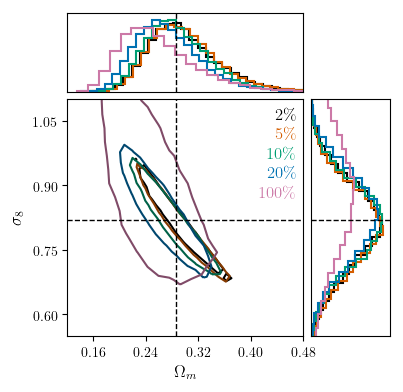

In [86]:
chains.plotter.plot(
    parameters=cosmo_param,
    truth=cosmo_truth,
    extents=[(0.12, 0.48), (0.55, 1.10)],
    figsize=(3.8, 3.8),
    legend=True
);